In [4]:
from pathlib import Path
import requests
import unicodedata
import json
from collections import Counter, defaultdict
import base64

from IPython.display import Image, display
import torch
import numpy as np
from jaxtyping import Int, Float
import matplotlib.pyplot as plt
import transformers
import transformer_lens

from utils.get_books import get_gutenberg_book, get_many_books
from utils.analyze_vocab import analyze_vocab

def mm(graph):
  """for plotting mermaid.js diagrams"""
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )


In [5]:
# magic auto-reload for local development
%load_ext autoreload
%autoreload 2

to install required packages:
```
pip install -r requirements.txt
```

# overview

- review:
	- tokenization
	- markov chains (bigrams)
	- n-grams
	- RNNs
- sparsity & homework
- attention

# Review



## Tokenization

- We start with a collection of text -- these are just strings of characters
- to feed it into a machine learning model, we need to convert it into a sequence of numbers
- this can be done a few ways:

In [6]:
# first, let's get some text to work with
my_text_full: str = get_gutenberg_book(84)
my_text: str = my_text_full[10000:11000]
print(my_text)

, to word my phrase

more characteristically, of advancement in his profession. He is an

Englishman, and in the midst of national and professional prejudices,

unsoftened by cultivation, retains some of the noblest endowments of

humanity. I first became acquainted with him on board a whale vessel;

finding that he was unemployed in this city, I easily engaged him to assist

in my enterprise.



The master is a person of an excellent disposition and is remarkable in the

ship for his gentleness and the mildness of his discipline. This

circumstance, added to his well-known integrity and dauntless courage, made

me very desirous to engage him. A youth passed in solitude, my best years

spent under your gentle and feminine fosterage, has so refined the

groundwork of my character that I cannot overcome an intense distaste to

the usual brutality exercised on board ship: I have never believed it to be

necessary, and when I heard of a mariner equally noted for his kindliness

of heart an

In [7]:
# tokenization with character-level vocabulary
char_vocab: list[str] = list(' abcdefghijklmnopqrstuvwxyz')
text_char_tokenized: list[int] = [
	char_vocab.index(c) if c in char_vocab else 0 # unknown token becomes a space
	for c in my_text
]
print(f"{len(char_vocab) = }, {len(text_char_tokenized) = }")

len(char_vocab) = 27, len(text_char_tokenized) = 1000


In [8]:
# tokenization with word-level vocabulary
word_vocab: list[str] = ['<unk>'] + list(set(''.join([
	c for c in my_text.lower()
	if c in char_vocab
]).split()))
text_word_tokenized: list[int] = [
	word_vocab.index(w) if w in word_vocab else 0 # unknown token becomes <unk>
	for w in my_text.lower().split()
]
print(f"{len(word_vocab) = }, {len(text_word_tokenized) = }")

len(word_vocab) = 104, len(text_word_tokenized) = 166


now, in reality these tokenizers are kind of lame:

- character encoding gives us a small vocabulary, but massive sequence length
- word encoding does not perfectly reconstruct the original text
- word encoding fails when we see a word we haven't seen before!
- all of these fail for languages in non-latin scripts

In [11]:
# but really, we just use a byte-pair encoding (BPE) tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
text_bpe_tokenized: list[int] = tokenizer.encode(my_text)
print(f"{tokenizer.vocab_size = }, {len(text_bpe_tokenized) = }")

tokenizer.vocab_size = 50257, len(text_bpe_tokenized) = 240


vocab_len_sorted[:20] = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4']
vocab_len_sorted[-20:] = ['................................', '================================', '________________________________', '********************************', 'ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ', '################################', 'rawdownloadcloneembedreportprint', '////////////////////////////////', ' --------------------------------', ' ********************************', ' =================================', '------------------------------------------------', '--------------------------------------------------------', '----------------------------------------------------------------', '................................................................', '================================================================', '________________________________________________________________', 'ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ

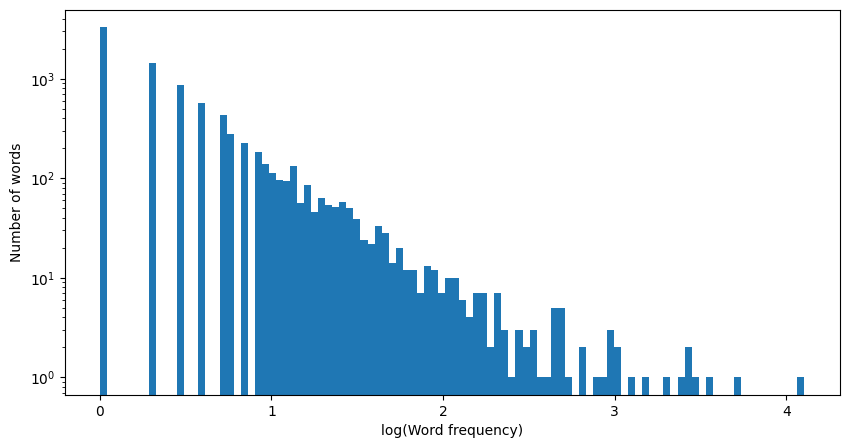

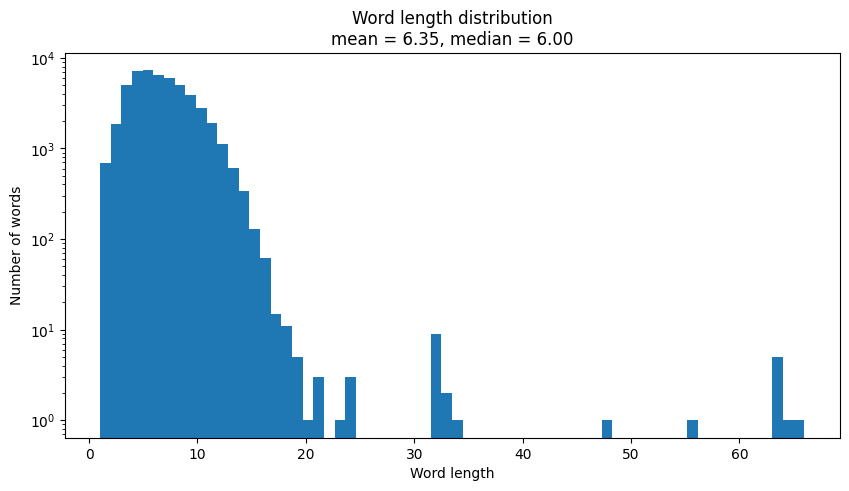

In [13]:
# what's in this tokenizer?
vocab_arr = [
	tokenizer.decode([i]) for i in range(tokenizer.vocab_size)
]
vocab_len_sorted = sorted(vocab_arr, key=len)
print(f"{vocab_len_sorted[:20] = }")
print(f"{vocab_len_sorted[-20:] = }")
# randomly sample tokens from the vocab
print(f"{np.random.choice(vocab_arr, 20) = }")
print(f"{len(vocab_len_sorted[-1]) = }")

# let's look at the distribution of token lengths
_ = analyze_vocab(tokenizer.tokenize(my_text_full), vocab_arr, bins_length=len(vocab_len_sorted[-1]))

### Rule of thumb for tokenization

with most commonly used LLM tokenizers, each token works out to about 0.7 words of english text:

In [11]:
print(f"{len(text_word_tokenized) / len(text_bpe_tokenized) = }")

len(text_word_tokenized) / len(text_bpe_tokenized) = 0.6916666666666667


## Markov Chains

for a vocabulary of size $d_V$, a markov chain is a matrix $M \in \mathbb{R}^{d_V \times d_V}$ where $M_{i,j}$ is the probability of transitioning from word $i$ to word $j$.

- the rows of $M$ sum to 1: $$ \sum_j M_{i,j} = 1 $$
- when initially creating the matrix, we start with $M_{i,j} = 0$ and add 1 to $M_{i,j}$ every time we see the word $i$ followed by the word $j$ in the training data (and then normalize the rows)

In other words, a markov chain gives us the probability of seeing any *pair* of words. Hence, a bigram.

## $n$-grams


We can extend this to an $n$-gram, by looking for how many times we see each sequence of $n$ words in the training data. For example, for $n=3$ (a *trigram*), we might count how many times we see the sequence of words "the cat sat" in the training data.

This means our $n$ gram requires a chain of dimension $d_V^n$ -- wildly impractical if we want to have more than a few words in our sequence.

## RNNs

$n$ grams end up having way too many parameters. We can try to get around this by taking a page from what we did with CNNs: we can *share* parameters across the sequence:

If we want an RNN which takes $n_c$ (`n_context`) tokens as input and produces a distribution over $d_V$ (`d_vocab`)

$$ \texttt{RNN} : \mathbb{R}^{n_c \times d_V} \to \mathbb{R}^{d_V} $$


we need a few things:

- define a "model" or "hidden" dimension $d_m$
- an *embedding* map $E : \R^{d_V} \to \R^{d_m}$ which takes a one-hot vector and produces a dense vector.
	- we also want its pair the *de-embedding* map, which we will term $E^{-1} : \R^{d_m} \to \R^{d_V}$ (although it's obviously not actually an inverse)
	- in the context of autoregressive language models, we hit the output of $E^{-1}$ with a softmax to get a distribution over the vocabulary
- a *recurrent* map $h : \R^{d_m} \times \R^{d_m} \to \R^{d_m}$ which takes the previous hidden state and the current input and produces the next hidden state
	- there are a couple different possible topologies here, and the hidden map can be a variety of things, but we will assume it's a dense neural net of some kind


Putting this together, we get:

$$
	x_{t+1} \sim \texttt{RNN}([x_{t-n_c}, \ldots, x_{t}]) = E^{-1} \left(q_t\right)
	\qquad
	q_t = h \left(
		\begin{matrix}
			E(x_{t}) \\
			q_{t-1}
		\end{matrix}
	\right)
$$

In [20]:
mm("""
graph LR
	xt(["x[t]"]) --> Et[[E]]
	Et --> h
	qtm1(["q[t-1]"]) --> h[[h]]
	h --> qt(["q[t]"])
	qt --> Einv[[E_inv]]
	Einv --> xk(["x[t+1]"])
    prev(((...))) --> qtm1
    qt --> next(((...)))
""")

# Sparsity, ~~and your homework!~~


we saw that for a vocab size of $\approx 5 \cdot 10^3$, a bigram model has $2.5 \cdot 10^7$ parameters, which is definitely manageable to keep on a modern computer -- but maybe a bit much for autocomplete on your phone.


We also noted, however, that the markov chain is *extremely sparse*.


~~Your homework 1 is as follows:~~

1. train a markov chain on a large text corpus, but using the gpt-2 tokenizer
2. investigate the sparsity of the resulting matrix in a more rigorous way than just the eyeball norm:
	- plot histograms of the weights
	- try to find the rank
	- take the SVD, and plot the singular values
	- other matrix decompositions or measures?
3. do some kind of investigation of your choice, and produce a legible juptyer notebook with your results. some possible questions might be:
	- can you *train* the sparse representation directly? (maybe use pytorch autodiff?)
	- are there any interesting clusters in the matrix? (hint: PCA, k-means, t-SNE, etc)
	- can you come up with sparse representations of trigrams? $n$-grams?
	- how do the results change if you use a different tokenizer? (i.e. our original word-based one)

Some guidelines:
- feel free to discuss in groups, but everyone should submit their own notebook
- use any code from notebooks or the internet, but cite your sources
- use chatGPT -- but you should be able to explain what is happening, and document the prompts you used!
- it's ok if what you tried doesn't work -- show me your code, make it understandable, and explain what you learned!


# Attention

So:
- dense networks fail because they re-learn the same thing at every position
- convolutional networks give the *spatial* prior to our networks, great for images
- RNNs give the *temporal* prior to our networks, great for sequences -- but they decay over time

When we actually process language, we care about more than just *local* relationships of this sort:

![](https://upload.wikimedia.org/wikipedia/commons/8/8c/Parse2.jpg)

Many scientists tried for a very long time to try to encode parse trees in machines, but using human knowledge ended up being far less effective than letting the machines pick it up themselves.

The key insight of transformers and modern large language models is the *attention mechanism:*

> Given some sequence of inputs $[x_1, \ldots, x_n]$, when trying to predict the next token $x_{n+1}$, long range dependencies can be captured by letting a network choose which previous tokens to pay *attention* to.


> note on notation: we're now switching to $x_i$ being already embedded vectors in $\R^{d_m}$, rather than one-hot vectors in $\R^{d_V}$

The attention mechanism is a map $\mathbb{A} : \R^{d_m} \times (\R^{d_m})^{n_c} \to \R^{d_m}$ which takes a *query* $x_q$ and a *key* $x_k$ and produces a weighted sum of the values. We first consider the computation of scalar attention $A_s: \R^{d_m} \times \R^{d_m} \to \R$ for some head $s$.

$$ A_s(x_q, x_k) = \sigma \left( c \cdot x_q Q_s (x_k K_s)^T \right) $$

What are all these symbols? Firstly, we define $d_h$: the *head dimension*. We usually pick a number of heads `n_heads` and set $d_h = d_m / n_h$. Think of each head as a separate attention mechanism, kind of like different kernels in a convolutional layer.

- $c$ is a constant scalar, usually set to $\frac{1}{\sqrt{d_h}}$
- $Q_s, K_s \in \R^{d_m \times d_h}$ are learned linear maps - we have a different set of weights for each head
- $\sigma$ is the softmax function


Now, once we have the scalar attention $A_s$, we can define the full attention map $A: \R^{d_m} \times \R^{d_m} \to \R^{d_m}$ as follows:

$$ \mathbb{A}(x_q) = [ A_s(x_q, x_k) x_q V_s ]_{s \in \N_{n_h}} $$

$$ = \left[ \sigma \left( \frac{1}{\sqrt{d_h}} \cdot x_q Q_s (x_k K_s)^T \right) x_q V_s \right]_{s \in \N_{n_h}} $$

where $W^Q_i, W^K_i, W^V_i \in \R^{d_m \times d_h}$ are learned linear maps, and $V_i \in \R^{d_m}$ are learned vectors.



the softmax function is given by:

$$
	[\sigma (\mathbf {z} )]_i
	= \frac {
		e^{z_i}
	}{
		\sum _{j=1}^{K}e^{z_j}
	}
$$